In [28]:
import mne
import numpy as np
import pandas as pd

In [29]:
# Load the raw bdf file
raw = mne.io.read_raw_bdf('/Users/tom/Desktop/psyco dat/test_2.bdf')

# drop all channels except A16, A13, A32, A31, A7, A24
raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','Status'])

rename_map = {
    'A16': 'Oz',
    'A13': 'Pz',
    'A32': 'Cz',
    'A31': 'Fz',
    'A24': 'T8',
    'A7': 'T7'
}

# Rename channels
raw.rename_channels(rename_map)



Extracting EDF parameters from /Users/tom/Desktop/psyco dat/test_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | test_2.bdf, 7 x 9699328 (4736.0 s), ~12 KiB, data not loaded>

In [30]:
min_duration = (2) / raw.info['sfreq']
events = mne.find_events(raw, min_duration=min_duration)

# print unique event IDs
unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)

Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
14177 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65382 65383]
Unique event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65382 65383]


In [31]:
logical_triggers = [x & 0xFF for x in events[:, 2]]
logical_triggers = pd.Series(logical_triggers, name='Logical Triggers')
print(logical_triggers.value_counts())

Logical Triggers
2      1379
7      1364
5      1322
1      1300
8      1291
9      1289
3      1263
6      1253
4      1235
103     834
101     814
102     573
19       33
15       33
11       30
14       29
13       26
16       26
18       24
17       22
12       20
10       17
Name: count, dtype: int64


In [32]:
# re reference the data to average of T7 and T8
raw.load_data()  # Load the data into memory
raw.set_eeg_reference(ref_channels=['T7', 'T8'], projection=False)
# decimate the data to 256Hz
raw.resample(256, npad='auto')
# filter above 30Hz lowpass
raw.filter(None, 30, fir_design='firwin', skip_by_annotation='edge')
# Save the modified raw data to a new file
raw.save('/Users/tom/Desktop/psyco dat/test_2-raw.fif', overwrite=True)

Reading 0 ... 9699327  =      0.000 ...  4736.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
14187 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65312 65376
 65381 65382 65383]
Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
14180 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65312 65349 65381 65382 65383]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple

[PosixPath('/Users/tom/Desktop/psyco dat/test_2-raw.fif')]

Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 564 original time points ...
39 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.


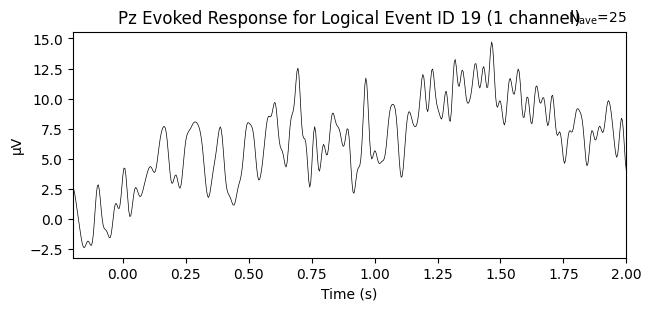

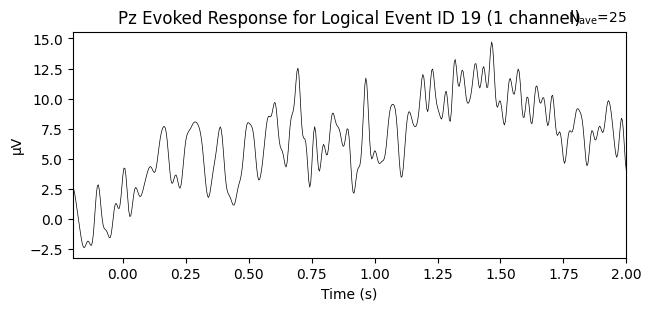

In [33]:
# Find indices of events with logical event ID 19
mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in events[:, 2]]
#mask = (events[:, 2] & 0xFF) == 102
events_19 = events[mask]
# only take first 32 events
events_19 = events_19[:64]

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 2  
epochs = mne.Epochs(raw, events_19, tmin=tmin, tmax=tmax, baseline=(-0.2, 0), preload=True)

# Get evoked response for Pz
evoked = epochs.average().pick('Cz')

# Plot the evoked response
evoked.plot(titles='Pz Evoked Response for Logical Event ID 19')